In [8]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt;
import torch.nn as nn


In [3]:
EPOCH = 3;
batch_size_train = 64;
batch_size_test = 1000;
lr = 0.01;momentum = 0.5
random_seed= 1;


In [4]:
torch.manual_seed(random_seed);#设置随机数种子
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/',train=True,download=True,
                                                                      transform=torchvision.transforms.Compose([
                                                                          torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))#二值化
                                                                    ])),batch_size=batch_size_train,shuffle=True);
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/',train=False,download=True,
                                                                     transform=torchvision.transforms.Compose([
                                                                         torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))
                                                                    ])),batch_size=batch_size_test,shuffle = True);


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!



/Users/eaglesmac/opt/anaconda3/envs/learnPy/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554845587/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
###dataset test###
examples=enumerate(test_loader);
batch_idx,(examples_data,examples_targets)=next(examples);
print(examples_data.shape);#---->torch.Size([1000, 1, 28, 28])说明这里是1000*1*28*28的矩阵(黑白双通道图像)


torch.Size([1000, 1, 28, 28])


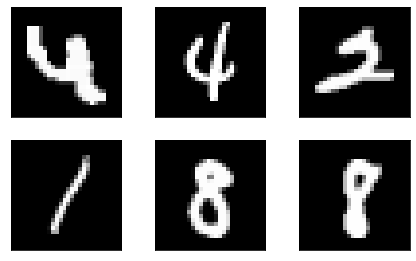

In [24]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1);
    plt.tight_layout();
    plt.imshow(examples_data[i][0],cmap='gray',interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [9]:
#构建模型
class NetWrok(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Sequential(nn.Conv2d(1,64,kernel_size=3,padding=1),#h=w=(28*2*1-3)/1+1=28
                                        nn.ReLU(),
                                        nn.Conv2d(64,128,kernel_size=3,padding=1),#h=w=(28*2*1-3)/1+1=28
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,2))#h=w=28/2=14
        self.fc = torch.nn.Sequential(nn.Linear(14*14*128,1024),
                                      nn.ReLU(),
                                      nn.Dropout2d(),#二维空间中的元素有50%的概率被置为0, 防止模型的过拟合
                                      nn.Linear(1024,10))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 14 * 14 * 128)
        x = self.fc(x)
        return F.log_softmax(x)

In [10]:
###训练
model= NetWrok()
model.to(device)
#loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
#optimizer = optim.Adam(model.parameters())
print(model)#查看模型结构
#用于保存模型
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCH + 1)]

NetWrok(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [14]:
def train(epochs):
    model.train()
    for batch_idx,(data,target)in enumerate(train_loader):
        optimizer.zero_grad()
        data=data.to(device)
        target = target.to(device)
        output = model(data)
        loss =F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        #每10个iter保存一次
        if batch_idx%10==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(model.state_dict(),'./run/MNIST/train/model.pth')
            torch.save(optimizer.state_dict(),'./run/MNIST/train/optimizer.pth')

In [15]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data,target in test_loader:
            data = data.to(device)
            target=target.to(device)
            output=model(data)
            test_loss += F.nll_loss(output,target,size_average=False).item()
            pred = output.data.max(1,keepdim=True)[1]
            correct+=pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
                        


In [16]:
for epoch in range(1,EPOCH+1):
    train(epoch)
    test()



<ipython-input-9-168ec425bf87>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294791
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.829239
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.306387
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.747914
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.596025
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.550432
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.549299
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.541047
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.664705
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.571712
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.522464
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.494310
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.342021
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.261658
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.473837
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.379444
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.509078
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.253452
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.353471
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.308322
Train Epoch: 1 [12800/60000 (

/Users/eaglesmac/opt/anaconda3/envs/learnPy/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0109, Accuracy: 969/10000 (10%)


Test set: Avg. loss: 0.0107, Accuracy: 1934/10000 (19%)


Test set: Avg. loss: 0.0111, Accuracy: 2899/10000 (29%)


Test set: Avg. loss: 0.0136, Accuracy: 3861/10000 (39%)


Test set: Avg. loss: 0.0145, Accuracy: 4814/10000 (48%)


Test set: Avg. loss: 0.0098, Accuracy: 5785/10000 (58%)


Test set: Avg. loss: 0.0127, Accuracy: 6745/10000 (67%)


Test set: Avg. loss: 0.0104, Accuracy: 7716/10000 (77%)


Test set: Avg. loss: 0.0100, Accuracy: 8687/10000 (87%)


Test set: Avg. loss: 0.0121, Accuracy: 9651/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.112175
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.204902
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.132156
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.060545
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.070139
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.039700
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.109652
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.129621
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.

Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.039876
Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.018424
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.008931
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.022772
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.043839
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.140017
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.017011
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.034202
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.038131
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.046281
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.037599
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.026415
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.039771
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.025312
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.050244
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.031174
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.087724
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.090580
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.081026
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.149224


In [20]:
with torch.no_grad():
  output = model(examples_data)

<ipython-input-9-168ec425bf87>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


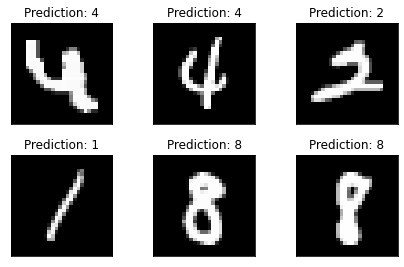

In [23]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(examples_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
